# Imports :

In [1]:
import numpy as np
import math
import scipy.io
import csv
from IPython.display import display
from scipy import sparse
import os.path
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from sklearn.feature_extraction.text import CountVectorizer
import re
from collections import Counter
from nltk.corpus import stopwords
import sklearn.neighbors, sklearn.linear_model, sklearn.ensemble, sklearn.naive_bayes
import time
import matplotlib.pyplot as plt
nltk.download("stopwords") 
nltk.download('punkt')
nltk.download('movie_reviews')
#removing stopwords
from nltk import word_tokenize,sent_tokenize

import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews


## drawing tools
# Load libraries

# Math
import numpy as np

# Visualization 
%matplotlib notebook 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage

# High-res visualization (but no rotation possible)
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')

# Print output of LFR code
import subprocess

# Sparse matrix
import scipy.sparse
import scipy.sparse.linalg

# 3D visualization
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

# Import data
import scipy.io

# Import functions in lib folder
import sys
sys.path.insert(1, 'lib')

# Import helper functions
%load_ext autoreload
%autoreload 2

# Import distance function
import sklearn.metrics.pairwise

# Remove warnings
import warnings
warnings.filterwarnings("ignore")




def find_between_r( s, first, last ):
    try:
        start = s.rindex( first ) + len( first )
        end = s.rindex( last, start )
        return s[start:end]
    except ValueError:
        return ""

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sbeuret/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sbeuret/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/sbeuret/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


# Datasets & Preprocessing

** Sentimental Analysis Text dataset: **

In [2]:
SAT_data =[]
with open('Projectdataset/Sentiment Analysis Dataset.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')#, quotechar='|')
    for row in spamreader:
        SAT_data.append(row) 
SAT_data = SAT_data[2:100]
SAT_data = [[row[1],row[3]] for row in SAT_data]
SAT_data = np.array(SAT_data)
SAT_data[:,0] = [int(float(x))*5 for x in SAT_data[:,0]]
SAT_data_chunk = SAT_data[0:8000]
print('Length = {} '.format(len(SAT_data)))
print('Type = {}'.format(type(SAT_data)))
print(SAT_data[0:5])


Length = 98 
Type = <class 'numpy.ndarray'>
[['0' '                   I missed the New Moon trailer...']
 ['5' '              omg its already 7:30 :O']
 ['0'
  "          .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)..."]
 ['0' '         i think mi bf is cheating on me!!!       T_T']
 ['0' '         or i just worry too much?        ']]


** Polarity Data: **

In [3]:
polarity_data = []
file1 = open("Projectdataset/rt-polaritydata/rt-polarity.neg", "r")
file2 = open("Projectdataset/rt-polaritydata/rt-polarity.pos", "r")
dataneg = file1.readlines();
datapos = file2.readlines();
dataneg = [i.replace('\n','') for i in dataneg]
datapos = [i.replace('\n','') for i in datapos]

zero = np.zeros(len(dataneg))
dataneg = np.column_stack ((zero , dataneg) )

one = 5*np.ones(len(datapos))
datapos = np.column_stack ((one , datapos) )

polarity_data = np.concatenate ((datapos,dataneg), axis = 0)
np.random.shuffle(polarity_data)
polarity_data[:,0] = [int(float(x)) for x in polarity_data[:,0]]

print('Length = {} '.format(len(polarity_data)))
print('Type = {}'.format(type(polarity_data)))
print(polarity_data[0:5])

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x97 in position 3118: invalid start byte

** Amazon dataset: **

In [3]:
Amazon_data = []
file4 = open("Projectdataset/amazonMP3reviews/amazon_mp3", "r")
data4 = file4.read()

data4 = data4.split("#####")
for i in range(1,100):#len(data4)):
    text = find_between_r( data4[i], "[fullText]:", "[rating]" )
    text = text.replace("\n",'')
    rating = find_between_r( data4[i],"[rating]:","[recommend]")
    Amazon_data.append([float(rating),text])
Amazon_data = np.asarray(Amazon_data)
Amazon_data_chunk = Amazon_data[0:8000]
Amazon_data[:,0] = [int(float(x)) for x in Amazon_data[:,0]]
print('Length = {} '.format(len(Amazon_data)))
print('Type = {}'.format(type(Amazon_data)))
print(Amazon_data[0:5])


Length = 99 
Type = <class 'numpy.ndarray'>
[['2'
  "It is good if you have internet than you can download the stuff, else, you can't  "]
 ['5'
  "The RIO rocks! It is so great that Diamond Multimedia prevailed in their fight against the forces of pure evil in the music industry and allowed us, the public, to have the RIO! This little baby holds your MP3's and plays  them with outrageous quality and no moving parts! You simply cannot make  the music &quot;skip&quot;. Take it jogging, bob sledding, whatever! The  Rio is cute and compact, battery lasts forever, runs great and is really  simple to use. Works well with the PC linkup, etc. A hot item!  "]
 ['4'
  'I had high hopes for the Diamond Rio and it certainly lived up 2 the hype. Lightweight and excellent quality with some good connecting software. My only gripe can be with memory. You definately need another 32Mb to store  your music. If you want one, my advice is to wait for the new upgraded  version with 64Mb and a graphic equali

** TripAdvisor dataset **

In [4]:
tripAdvisor_data1 = []
path = 'Projectdataset/tripadvisor/Aspects'
dirs = os.listdir(path)


for direct in dirs:
    #print(direct)
    file5 = open(path+'/'+direct, "r")
    data5 = file5.read()
    data5 = data5.split("<Author>")
    data5 = data5[1:]
    for data in data5:
        ignore = False;
        text = find_between_r( data, "<Content>", "<Date>")
        text = text.replace("\n",'')
        rank = find_between_r( data, "<Rating>", "<Aspects>")
        rank = rank.rstrip().split('\t') 
        if (rank ==['']):
                ignore = True
        if not (ignore): 
            rank = [float(x) for x in rank]
            rank =round(np.mean(rank))
            tripAdvisor_data1.append((rank, text))
       
        
            


In [5]:
tripAdvisor_data2=np.asarray(tripAdvisor_data1[0:9000])
#tripAdvisor_data1=np.asarray(tripAdvisor_data1)
#tripAdvisor_data1=np.array(tripAdvisor_data1)
print('Length = {} '.format(len(tripAdvisor_data1)))
print('Type = {}'.format(type(tripAdvisor_data1)))
print(tripAdvisor_data1[0:5])


Length = 198979 
Type = <class 'list'>
[(5.0, "Average Hotel Good hotel for the price I paid. The service was excelent. The only thing that I didn't like and I was very angry about was the suppose Free Continental Breakfast . You have to go to the restaurant and they only give coffee or orange juice and a toast and that's it. If you want a omelet or something like that the prices are way up to high. I recommend to eat breakfast in the Ponderosa Restaurant that is very close to the hotel, about a 5 minute walk. The hotel is very close to the beach, just crossing the street. The location is great because is in the heart of Isla Verde. You can go to others hotels, pubs etc... also the pool is nice. They have a Restaurant called Fascio Pizza.....excelent! Don't eat in the one where is the free continental breakfast...is pricey.  "), (5.0, 'Affordable Safe  Isla Verde - Booking this Hotel was very convenient and affordable on the Howard Johnson Hotel- Carolina website or call [--], (car ren

** Sorted Data ACL **

In [5]:
#################################### Books ######################################################
books_data = []
file7 = open('Projectdataset/sorted_data_acl/books/negative.review', "r")
file8 = open('Projectdataset/sorted_data_acl/books/positive.review', "r")

negative = file7.read()
positive = file8.read()
######## books
negative = negative.split("<review>")
positive = positive.split("<review>")
negative = negative[1:]
positive = positive[1:]

a = []
b = []
for neg in negative:
    text = find_between_r( neg, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( neg, "<rating>", "</rating>")
    a.append((rate,text))
    
for pos in positive:
    text = find_between_r( pos, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( pos, "<rating>", "</rating>")
    b.append((rate,text))

books_data = np.concatenate((a,b) , axis = 0)
np.random.shuffle(books_data)
print("books review")
print('Length = {} '.format(len(books_data)))
print('Type = {}'.format(type(books_data)))
#print(books_data)

#################################### DVDs ######################################################
DVD_dataset= []
file9 = open('Projectdataset/sorted_data_acl/dvd/negative.review', "r")
file10 = open('Projectdataset/sorted_data_acl/dvd/positive.review', "r")
negative = file9.read()
positive = file10.read()

negative = negative.split("<review>")
positive = positive.split("<review>")
negative = negative[1:]
positive = positive[1:]

a = []
b = []
for neg in negative:
    text = find_between_r( neg, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( neg, "<rating>", "</rating>")
    a.append((rate,text))
    
for pos in positive:
    text = find_between_r( pos, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( pos, "<rating>", "</rating>")
    b.append((rate,text))


DVD_dataset = np.concatenate((a,b) , axis = 0)
np.random.shuffle(DVD_dataset)
print("dvds_review")
print('Length = {} '.format(len(DVD_dataset)))
print('Type = {}'.format(type(DVD_dataset)))
#print(DVD_dataset)

#################################### Electronics ######################################################
electronics_data = []
file11 = open('Projectdataset/sorted_data_acl/electronics/negative.review', "r")
file12 = open('Projectdataset/sorted_data_acl/electronics/positive.review', "r")

negative = file11.read()
positive = file12.read()

negative = negative.split("<review>")
positive = positive.split("<review>")
negative = negative[1:]
positive = positive[1:]

a = []
b = []
for neg in negative:
    text = find_between_r( neg, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( neg, "<rating>", "</rating>")
    a.append((rate,text))
    
for pos in positive:
    text = find_between_r( pos, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( pos, "<rating>", "</rating>")
    b.append((rate,text))

electronics_data = np.concatenate((a,b) , axis = 0)
np.random.shuffle(electronics_data)
print("electronics_review")
print('Length = {} '.format(len(electronics_data)))
print('Type = {}'.format(type(electronics_data)))
#print(electronics_data)
########################################## kitchen_&_housewares ##############################################
kh_dataset = []
file13 = open('Projectdataset/sorted_data_acl/kitchen_&_housewares/negative.review', "r")
file14 = open('Projectdataset/sorted_data_acl/kitchen_&_housewares/positive.review', "r")

negative = file13.read()
positive = file14.read()

negative = negative.split("<review>")
positive = positive.split("<review>")
negative = negative[1:]
positive = positive[1:]

a = []
b = []
for neg in negative:
    text = find_between_r( neg, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( neg, "<rating>", "</rating>")
    a.append((rate,text))
    
for pos in positive:
    text = find_between_r( pos, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( pos, "<rating>", "</rating>")
    b.append((rate,text))

kh_dataset = np.concatenate((a,b) , axis = 0)
np.random.shuffle(kh_dataset)
print("kh_review")
print('Length = {} '.format(len(kh_dataset)))
print('Type = {}'.format(type(kh_dataset)))

review_data = np.concatenate((books_data,DVD_dataset,electronics_data,kh_dataset))
np.random.shuffle(review_data)
print("review_data")
print('Length = {} '.format(len(review_data)))
print('Type = {}'.format(type(review_data)))
review_data[:,0] = [int(float(x)) for x in review_data[:,0]]
print(review_data[0:5])

books review
Length = 2000 
Type = <class 'numpy.ndarray'>
dvds_review
Length = 2000 
Type = <class 'numpy.ndarray'>
electronics_review
Length = 2000 
Type = <class 'numpy.ndarray'>
kh_review
Length = 2000 
Type = <class 'numpy.ndarray'>
review_data
Length = 8000 
Type = <class 'numpy.ndarray'>
[['2'
  'i am currently subjecting myself to finance curriculum at a quant-heavy, top-5 bschool.  this text was recommended for my Intro Cap Markets class (although the prof didnt exactly use it in the class).i often used it to gain understanding of what was taught in class.  unfortunately, i found this book to be EXTREMELY painful.  it was verbose, overly complicated, hard to read, poorly organized & full of jargon.  while it is thorough in its coverage of Capital Markets & instruments, i found it to be nearly impossible to read.esoteric theories & mathematical proofs were introduced with little background, and often without insufficient detail to understand grasp.  but the jargon & vocabulary 

# Naive Bayes Classification
This classifier is only used when we have binary classification. Here we applied it just as a trial.

In [6]:
def word_feats(words):
        return dict([(word, True) for word in words])
    
negids = movie_reviews.fileids('neg')
posids = movie_reviews.fileids('pos')
 
negfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'neg') for f in negids]
posfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'pos') for f in posids]

negcutoff = int(len(negfeats)*3/4)
poscutoff = int(len(posfeats)*3/4)

trainfeats = negfeats[:negcutoff] + posfeats[:poscutoff]
testfeats = negfeats[negcutoff:] + posfeats[poscutoff:]
print('train on %d instances, test on %d instances' % (len(trainfeats), len(testfeats)))
 
classifier = NaiveBayesClassifier.train(trainfeats)
print('accuracy:', nltk.classify.util.accuracy(classifier, testfeats))
classifier.show_most_informative_features()

train on 1500 instances, test on 500 instances
accuracy: 0.728
Most Informative Features
             magnificent = True              pos : neg    =     15.0 : 1.0
             outstanding = True              pos : neg    =     13.6 : 1.0
               insulting = True              neg : pos    =     13.0 : 1.0
              vulnerable = True              pos : neg    =     12.3 : 1.0
               ludicrous = True              neg : pos    =     11.8 : 1.0
                  avoids = True              pos : neg    =     11.7 : 1.0
             uninvolving = True              neg : pos    =     11.7 : 1.0
             fascination = True              pos : neg    =     10.3 : 1.0
              astounding = True              pos : neg    =     10.3 : 1.0
                 idiotic = True              neg : pos    =      9.8 : 1.0


# Feature Extraction
** Bag of Words Feature Extraction ** 






In [6]:
def column(matrix, i):
    return [row[i] for row in matrix]
def compute_bag_of_words(text, nwords):
    vectorizer = CountVectorizer(max_features=nwords)
    vectors = vectorizer.fit_transform(text)
    vocabulary = vectorizer.get_feature_names()
    return vectors, vocabulary

nwords = 300 # number of words to represent text

# all datasets texts
#text_polarity = column(polarity_data,1)
text_amazon = column(Amazon_data_chunk,1)
text_sat = column(SAT_data_chunk,1)
text_trip = column(tripAdvisor_data2,1)
#text_items = column(review_data,1)
# all datasets ratings
#Y_polarity = np.asarray(column(polarity_data,0))
Y_amazon = np.asarray(column(Amazon_data_chunk,0))
Y_sat = np.asarray(column(SAT_data_chunk,0))
Y_trip = np.asarray(column(tripAdvisor_data2,0))
#Y_items = np.asarray(column(review_data,0))

#names = ["Polarity Dataset","Amazon Dataset","SAT dataset","Trip Advisor","Items"]
names = ["Amazon Dataset","SAT dataset","Trip Advisor"]
#texts = [text_polarity,text_amazon,text_sat,text_trip,text_items]
texts = [text_amazon,text_sat,text_trip]
#Ys = [Y_polarity , Y_amazon, Y_sat, Y_trip, Y_items]
Ys = [ Y_amazon, Y_sat, Y_trip]
stop_words = set(stopwords.words('english'))

filtered_data =[]
bows = []
i = 0

for textset in texts:
    filtered=[];
    for item in textset:
        words = word_tokenize(item)
        words =[word.lower() for word in words]
        filtered_item=[];
        for w in words:
            if w not in stop_words:
                filtered_item.append(w)
        result = ' '.join(filtered_item)
        filtered.append(result)
    bow, vocab = compute_bag_of_words(filtered, nwords)
    bows.append(bow)
    print("Dataset ={}".format(names[i]))
    print("Length = {}".format(len(filtered))) 
    print("bow = {}".format(bow.shape))
    print("Y = {}".format(Ys[i].shape))
    filtered_data.append(filtered)
    i += 1


Dataset =Amazon Dataset
Length = 99
bow = (99, 300)
Y = (99,)
Dataset =SAT dataset
Length = 98
bow = (98, 300)
Y = (98,)
Dataset =Trip Advisor
Length = 9000
bow = (9000, 300)
Y = (9000,)


# Dividing into Training data and Testing data

In [7]:

X_trains = []
X_tests = []
Y_trains = []
Y_tests = []
i = 0
for textset in texts:
    cutoff = math.ceil(len(Ys[i])*0.75)
    print(cutoff)
    X_trains.append(bows[i][0:cutoff])
    X_tests.append(bows[i][cutoff:])
    Y_trains.append(Ys[i][0:cutoff])
    Y_tests.append(Ys[i][cutoff:])
    i+=1


75
74
6750


# Classifiers and using the right one

In [22]:

# The different classifiers
clf, train_accuracy, test_accuracy, exec_time = [], [], [], []
clf.append(sklearn.neighbors.KNeighborsClassifier()) # k-NN classifier
clf.append(sklearn.svm.LinearSVC()) # linear SVM classifier
clf.append(sklearn.linear_model.LogisticRegression()) # logistic classifier
clf.append(sklearn.ensemble.RandomForestClassifier())
clf.append(sklearn.linear_model.RidgeClassifier())
clf.append(sklearn.naive_bayes.BernoulliNB())
clf.append(sklearn.naive_bayes.MultinomialNB())


train_accuracies = []
test_accuracies = []
cross_val_values=[]


# train on different datasets 
for i in range (0,len(names)):
    print("Dataset = {}".format(names[i]))
    classifier = ['KNN','SVM','Log-R','RanF', 'RC','B','MultiNB']
    j = 0
    train_accuracy = []
    test_accuracy = []
    cross_val_value = []
    for c in clf:
        #t_start = time.process_time()
        c.fit(X_trains[i], Y_trains[i])
        train_pred = c.predict(X_trains[i])
        test_pred = c.predict(X_tests[i])
        train_accuracy .append( '{:5.2f}'.format(100*sklearn.metrics.accuracy_score(Y_trains[i], train_pred)) )
        test_accuracy .append( '{:5.2f}'.format(100*sklearn.metrics.accuracy_score(Y_tests[i], test_pred)) )
        cross_val_value.append('{:5.2f}'.format(100*np.mean(sklearn.model_selection.cross_val_score(c,X_trains[i],Y_trains[i],cv=10))))
        #exec_time.append('{:5.2f}'.format(time.process_time() - t_start))
        print('Classifier:          {}'.format(classifier[j]))
        print('Train accuracy:      {}'.format(train_accuracy[j]))
        print('Test accuracy:       {}'.format(test_accuracy[j]))
        print('Cross validation:    {}'.format(cross_val_value[j]))
        j+=1
        #print('Execution time:      {}'.format(exec_time))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    cross_val_values.append(cross_val_value)

Dataset = Amazon Dataset
Classifier:          KNN
Train accuracy:      52.00
Test accuracy:       29.17
Cross validation:    34.63
Classifier:          SVM
Train accuracy:      100.00
Test accuracy:       45.83
Cross validation:    47.48
Classifier:          Log-R
Train accuracy:      100.00
Test accuracy:       50.00
Cross validation:    50.58
Classifier:          RanF
Train accuracy:      100.00
Test accuracy:       37.50
Cross validation:    34.38
Classifier:          RC
Train accuracy:      100.00
Test accuracy:       45.83
Cross validation:    48.34
Classifier:          B
Train accuracy:      72.00
Test accuracy:       20.83
Cross validation:    30.75
Classifier:          MultiNB
Train accuracy:      93.33
Test accuracy:       45.83
Cross validation:    41.08
Dataset = SAT dataset
Classifier:          KNN
Train accuracy:      81.08
Test accuracy:       87.50
Cross validation:    69.35
Classifier:          SVM
Train accuracy:      98.65
Test accuracy:       58.33
Cross validation: 

IndexError: list index out of range

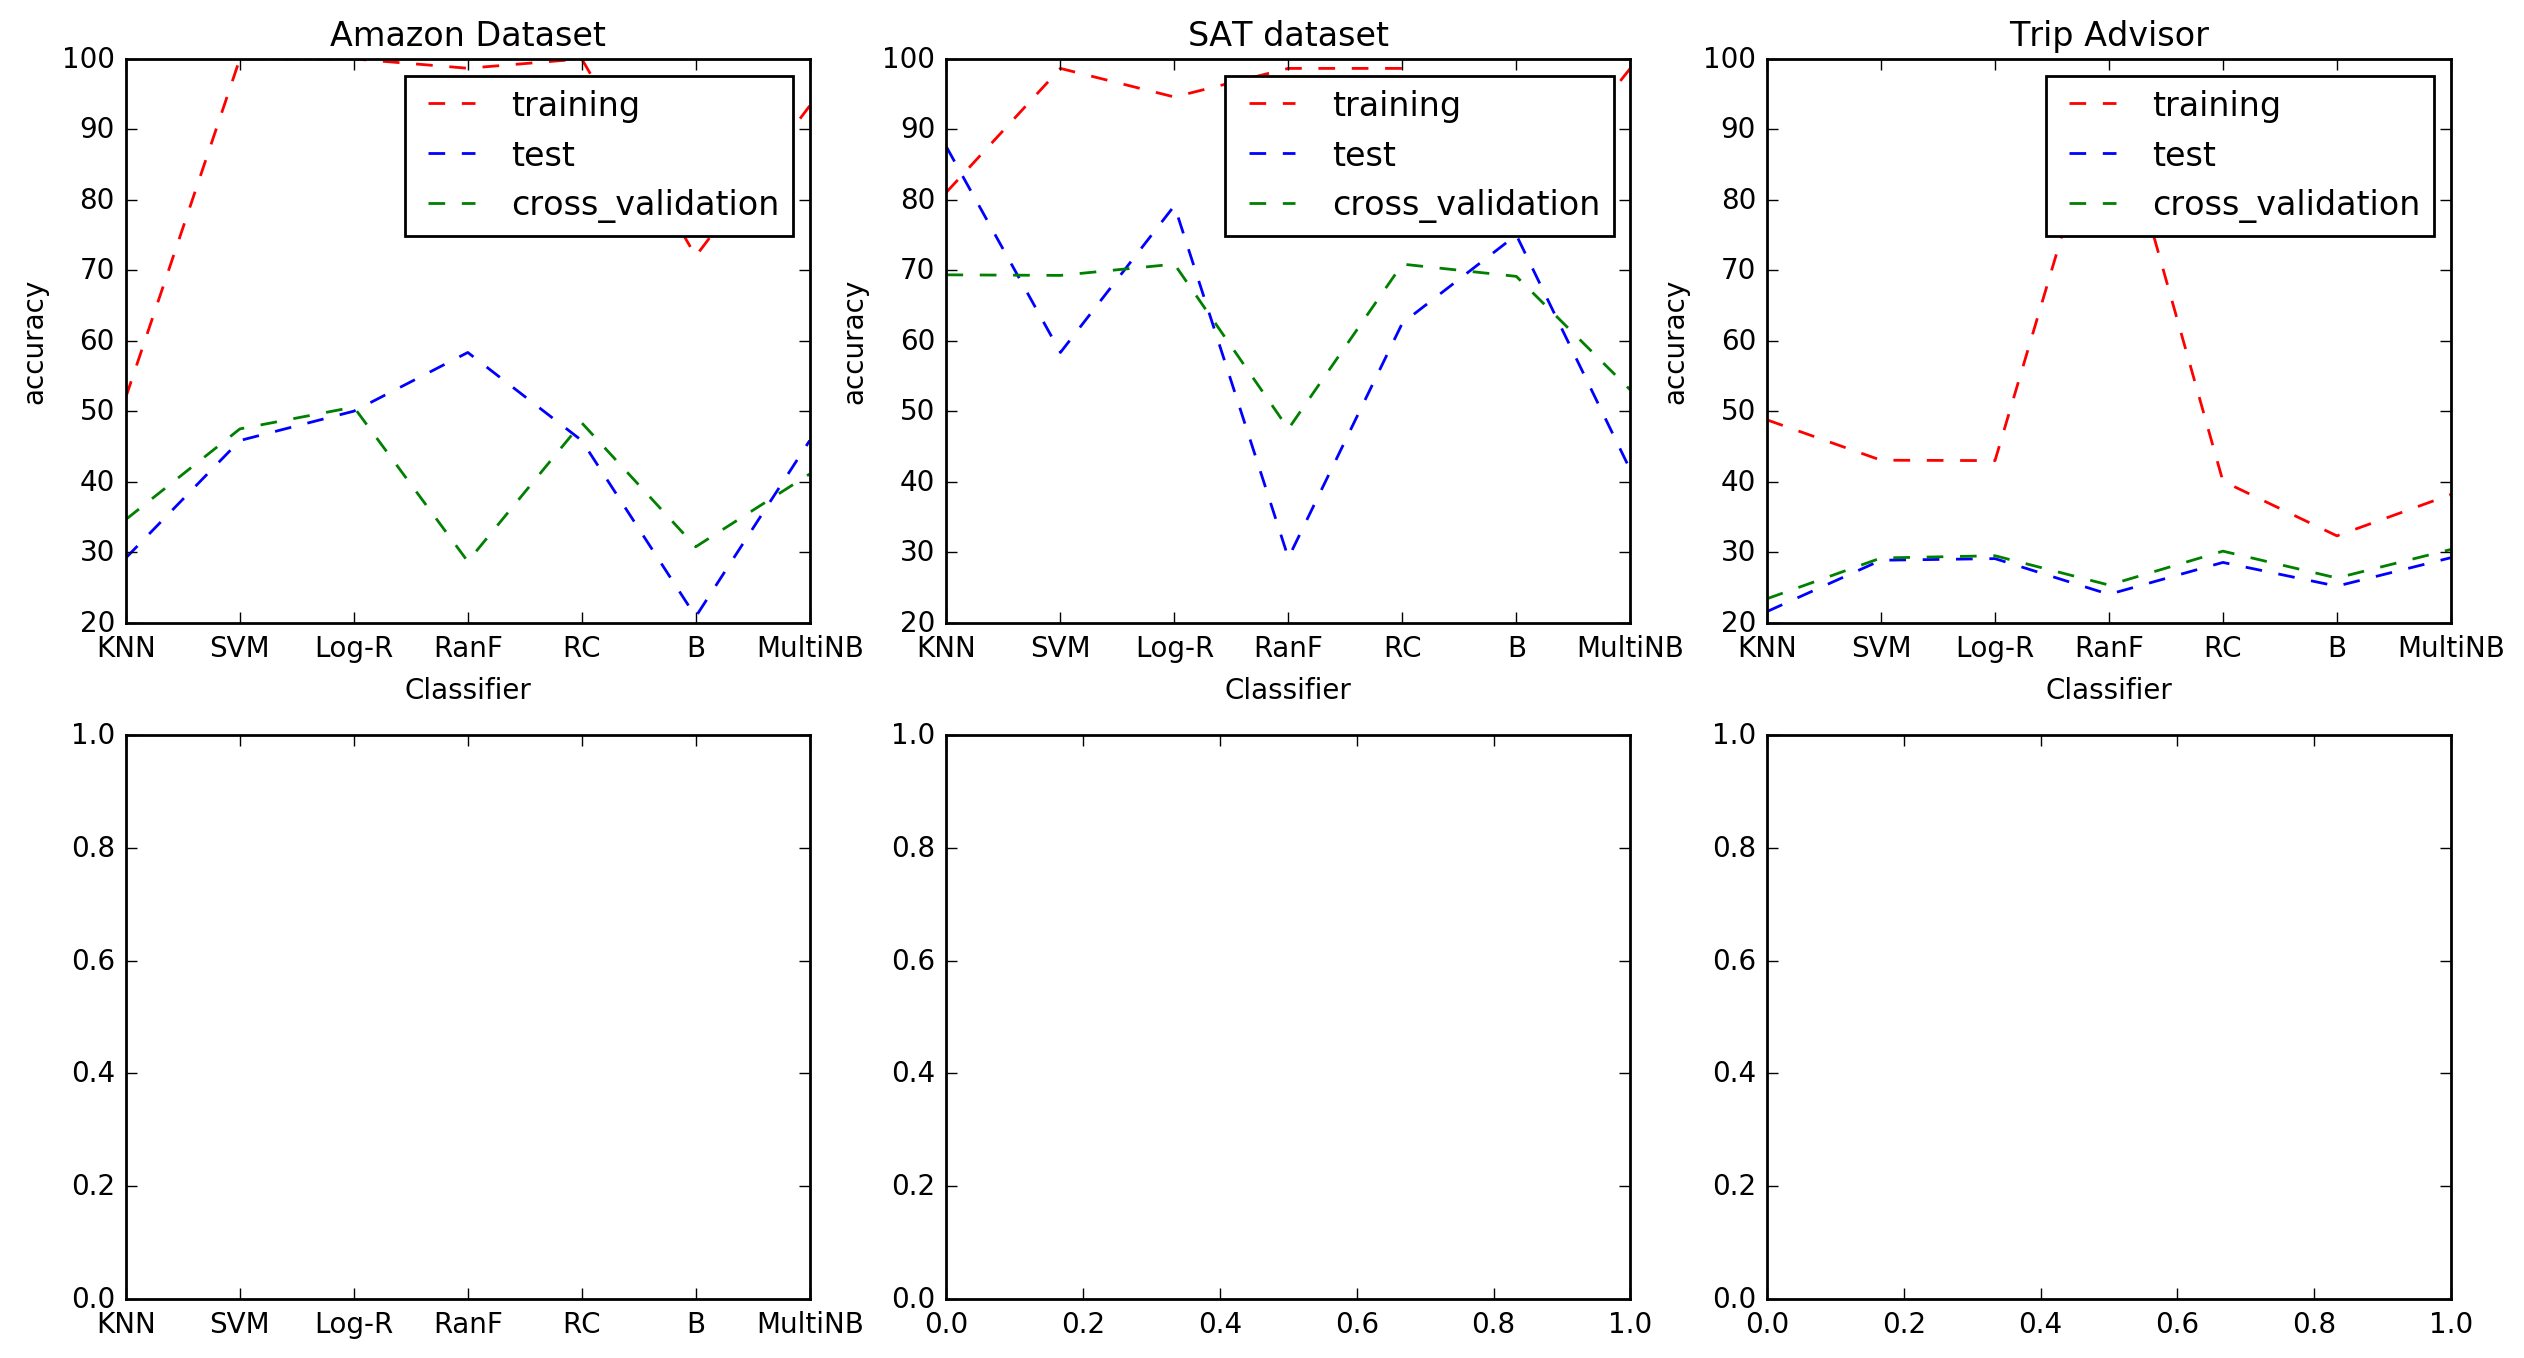

In [21]:
x =[0,1,2,3,4,5,6]
classifier = ['KNN','SVM','Log-R','RanF', 'RC','B','MultiNB']
Leg = ["training","test","cross_validation"]
n = 5
fig, axes = plt.subplots(2, 3, squeeze=True, figsize=(15, 8))
for i in range(n):
    axes[i//3,i%3].set_xticks(x)
    axes[i//3,i%3].set_xticklabels(classifier, fontdict=None, minor=False)
    axes[i//3,i%3].plot(x,train_accuracies[i],"r--",x,test_accuracies[i],"b--",cross_val_values[i],"g--")
    axes[i//3,i%3].set_title(names[i])
    axes[i//3,i%3].set_ylabel("accuracy")
    axes[i//3,i%3].set_xlabel("Classifier")
    axes[i//3,i%3].legend(Leg)

for i in range(n):  
    display("Dataset: {} ".format(names[i]))
    value = max(test_accuracies[i])
    index = test_accuracies[i].index(value)
    display("best test accuracy = {}  for = {}".format(value,classifier[index]))
    
    
#plt.xticks(x,classifier)#,names,knn_test,"b--")
#plt.plot(x,train_accuracies[0],"r--",x,test_accuracies[0],"b--")



#plt.show()

# Incremental Learning 
Due to memory limitation we can't apply the classifier on the whole chunck of data at the same time.Therefore we use partial training of classifiers. 

In [73]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB

test_stats = {'n_test': 0, 'n_test_pos': 0}
def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s


Overall_data = [SAT_data,Amazon_data,polarity_data,review_data]
batches = []
#Y_polarity = np.unique(np.asarray(column(SAT_data,0)))
#Y_amazon = np.unique(np.asarray(column(Amazon_data,0)))
#Y_sat = np.unique(np.asarray(column(polarity_data,0)))
#Y_items = np.unique(np.asarray(column(review_data,0)))
#y_all =np.unique(np.concatenate((Y_polarity,Y_amazon,Y_sat,Y_items),axis = 0))
print(y_all)
minibatch_size = 10000

# divide data into batches
i = 0
while (i<len(Overall_data)):
    start = 0
    trans = False
    leftover_len = 0
    while not(trans):
        if not(leftover_len == 0):
            batch = np.concatenate ((leftover , Overall_data[i][start:start + minibatch_size - leftover_len]), axis = 0)
            batches.append(batch)
            start = start + minibatch_size - leftover_len
            leftover_len = 0
        elif not (start + minibatch_size >= len(Overall_data[i]) ):
            batch = Overall_data[i][start:start + minibatch_size]
            batches.append(batch)
            start = start + minibatch_size
        else: 
            leftover_len = len(Overall_data[i]) - start
            leftover = Overall_data[i][start:]
            trans = True
            start = 0
            
        
    i += 1

        
#Classifiers      
partial_fit_classifiers = {
    'SGD': SGDClassifier(),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}
        
                  
cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

number_minibatch = len(batches)
total_vect_time = 0.0
all_classes = np.array([0, 1 , 2, 3, 4 ,5])
    
print(number_minibatch)
# Main loop : iterate on mini-batches of examples
for i in range(number_minibatch):
    print("Batch number = {}".format(i))
    batch = batches[i]
    textset = column(batch,1)
    filtered=[]
    for item in textset:
        words = word_tokenize(item)
        words =[word.lower() for word in words]
        filtered_item=[];
        for w in words:
            if w not in stop_words:
                filtered_item.append(w)
        result = ' '.join(filtered_item)
        filtered.append(result)
    X, vocab = compute_bag_of_words(filtered, nwords)
    Y = column(batch,0)

    cutoff = math.ceil(len(Y)*0.75)
    X_train = X#[0:cutoff]
    X_test = X[cutoff:]
    y_train = Y#[0:cutoff]
    y_test = Y[cutoff:]
    test_stats['n_test'] += len(y_test)
    test_stats['n_test_pos'] += sum([int(x) for x in y_test])
    
    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=y_all)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum([int(x) for x in y_train])
        tick = time.time()

        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats[cls_name]['accuracy'],
                       total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

        if i % 10 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if i % 3 == 10:
        print('\n')

['0' '1' '2' '3' '4' '5']
161
Batch number = 0
                 SGD classifier : 	 10000 train docs ( 20945 positive)   2500 test docs (  7340 positive) accuracy: 0.678 in 2.56s ( 3905 docs/s)
          Perceptron classifier : 	 10000 train docs ( 20945 positive)   2500 test docs (  7340 positive) accuracy: 0.686 in 2.58s ( 3881 docs/s)
      NB Multinomial classifier : 	 10000 train docs ( 20945 positive)   2500 test docs (  7340 positive) accuracy: 0.714 in 2.58s ( 3881 docs/s)
  Passive-Aggressive classifier : 	 10000 train docs ( 20945 positive)   2500 test docs (  7340 positive) accuracy: 0.677 in 2.59s ( 3858 docs/s)
Batch number = 1
Batch number = 2
Batch number = 3
Batch number = 4
Batch number = 5
Batch number = 6
Batch number = 7
Batch number = 8
Batch number = 9
Batch number = 10
                 SGD classifier : 	110000 train docs (312280 positive)  27500 test docs ( 80880 positive) accuracy: 0.716 in 28.82s ( 3817 docs/s)
          Perceptron classifier : 	110000 train doc

# Performance and Visualization of Incremental Learning classifier 

In [74]:
#Performance of the classifiers 
print("Accuracy of SGD is {}".format(cls_stats['SGD']['accuracy']) )
print("Accuracy of Perceptron is {}".format(cls_stats['Perceptron']['accuracy']) )
print("Accuracy of NB Multinomial is {}".format(cls_stats['NB Multinomial']['accuracy']) )
print("Accuracy of Passive-Aggressive is {}".format(cls_stats['Passive-Aggressive']['accuracy']) )



Accuracy of SGD is 0.6216
Accuracy of Perceptron is 0.6132
Accuracy of NB Multinomial is 0.516
Accuracy of Passive-Aggressive is 0.6316


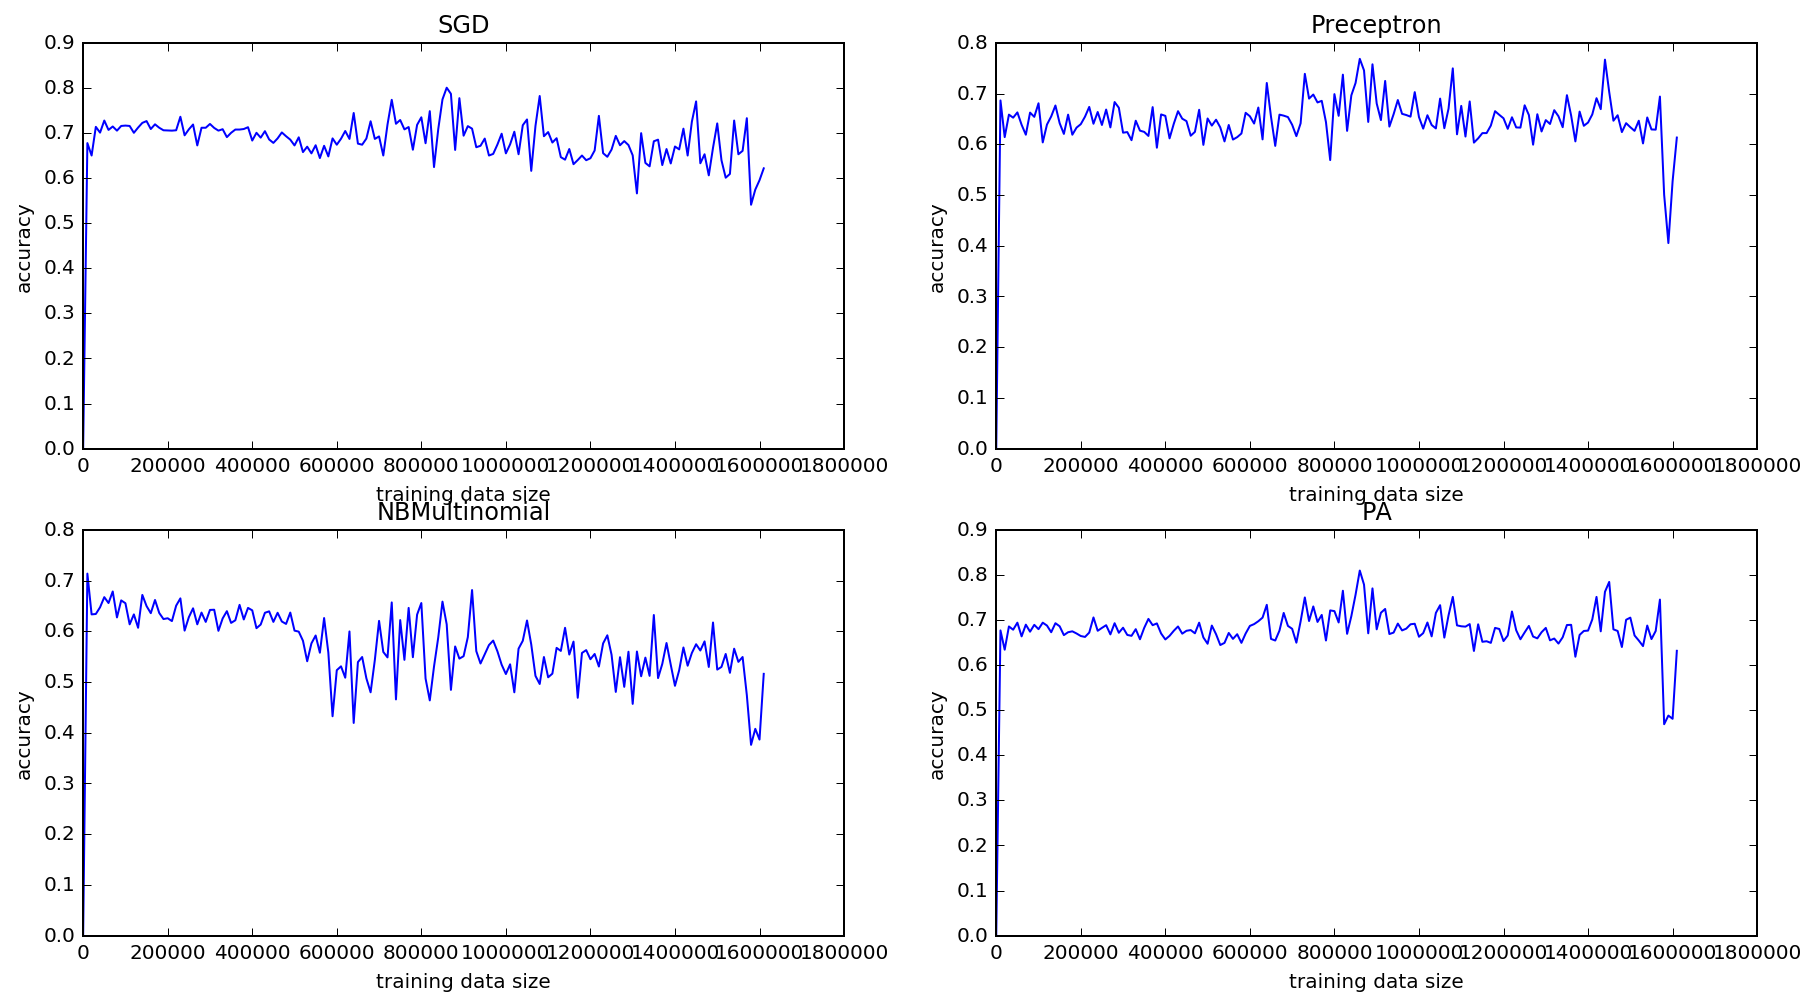

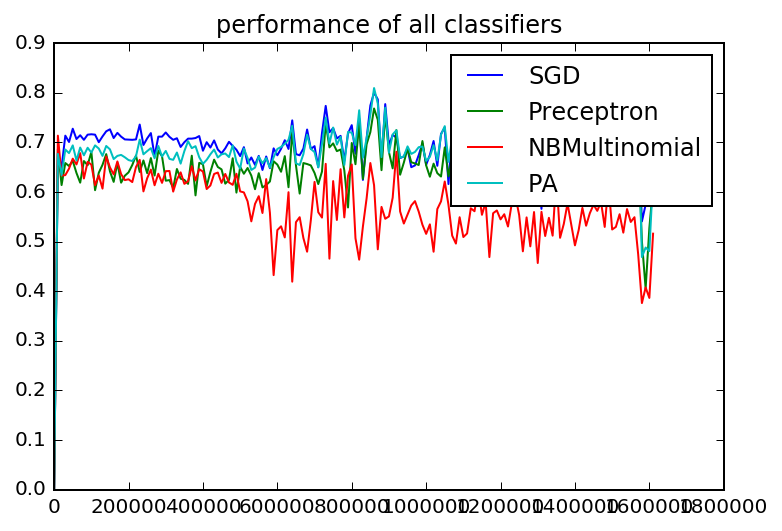

In [75]:
#Visualization of performance throughout learning process
accuracies_SGD = [x[0] for x in cls_stats['SGD']['accuracy_history']]
train_SGD = [x[1] for x in cls_stats['SGD']['accuracy_history']]
accuracies_Perceptron = [x[0] for x in cls_stats['Perceptron']['accuracy_history']]
train_Perceptron = [x[1] for x in cls_stats['Perceptron']['accuracy_history']]
accuracies_NBMultinomial = [x[0] for x in cls_stats['NB Multinomial']['accuracy_history']]
train_NBMultinomial = [x[1] for x in cls_stats['NB Multinomial']['accuracy_history']]
accuracies_Passive_Aggressive = [x[0] for x in cls_stats['Passive-Aggressive']['accuracy_history']]
train_Passive_Aggressive = [x[1] for x in cls_stats['Passive-Aggressive']['accuracy_history']]



accuracies=[accuracies_SGD,accuracies_Perceptron,accuracies_NBMultinomial,accuracies_Passive_Aggressive]
train=[train_SGD,train_Perceptron,train_NBMultinomial,train_Passive_Aggressive]

n = 4
fig, axes = plt.subplots(2,2, squeeze=True, figsize=(15, 8))
for i in range(n):
    axes[i//2,i%2].plot(train[i],accuracies[i])
    axes[i//2,i%2].set_title(titles[i])
    axes[i//2,i%2].set_ylabel("accuracy")
    axes[i//2,i%2].set_xlabel("training data size")

plt.figure()
plt.plot(train_SGD,accuracies_SGD,train_Perceptron,accuracies_Perceptron, train_NBMultinomial,accuracies_NBMultinomial 
         ,train_Passive_Aggressive,accuracies_Passive_Aggressive)
plt.title("performance of all classifiers")
plt.legend(titles)
  

# Political posts from Facebook and Twitter 

Goal: collect comments from political posts on Facebook and Twitter to evaluate the response of the audience (positive,negative).

In [42]:
# Number of posts / tweets.
n = 20  

## Facebook

In [43]:
import configparser

credentials = configparser.ConfigParser()
credentials.read('credentials.ini')
token = credentials.get('facebook', 'token')

import requests  
import facebook 
import pandas as pd

#testing with EPFL page, run it with the page of a politician's page
page = 'EPFL.ch'

In [59]:

fields = 'id,message,comments.limits(0).summary(1)'
url = 'https://graph.facebook.com/{}/posts?fields={}&access_token={}'.format(page, fields, token)

#To do: get the demographics of the commentors 
#user-id?fields=id, name,age_range,currency,gender,hometown,location,political,religion,relationship_status,work,education

fb = pd.DataFrame(columns=['comment message','post message','post time']) # 'user name', 'age', 'gender','hometown','political','religion','education'])

serie={'comment message':[],'post message':[],'post time':[]};

while len(fb) < n:
    
    posts = requests.get(url).json()
    
    i=0
    # extract information for each of the received post
    for post in posts['data']:
        
        i=i+1 
        print('post n°' , i)
        #print(post)
        
        
        try:
            # Only work with posts with text.
            post_message = post['message']
            try:
                # Only work with posts with comments which have text.
                nb_comments_per_post=post['comments']['summary']['total_count']
                print(nb_comments_per_post,' comments')
                
                x= post['comments']['data'][0]['message'] #IndexError if no comment on the page, only work with posts
                # which have at least 1 comment
                for comment in range(0,nb_comments_per_post ):
                    print('comment n°',comment)
                    serie['comment message'] =  post['comments']['data'][comment]['message']
                    print(post['comments']['data'][comment]['message'])
                    
                    serie['post message']= post['message']
                    serie['post time']=post['created_time'];
                    
                    fb = fb.append(serie, ignore_index=True)
                                        
            except IndexError or KeyError:
                continue 
        except KeyError:
            continue

        
    try:
        
        url = posts['paging']['next']
    except KeyError:
        
        break
 


post n° 1
2  comments
comment n° 0
Mon fils est paraplégique est si jamais vous avez besoin de volontaire ou de cobaye, nous serions intéressés, on sait jamais......remarcher serait une découverte extraordinaire......
comment n° 1
Impressive achievements !
post n° 2
5  comments
comment n° 0
Daniele questa è  la scuola
comment n° 1
Bonne Année!
comment n° 2
Happy new year ❤🍀🍀🍀🤓
comment n° 3
happy new year
comment n° 4
I'm proud to be part of it !
post n° 3
4  comments
comment n° 0
Thomas, Das ist was Ich meine.
comment n° 1
Bello!
comment n° 2
Sergio Monticciolo
comment n° 3
post n° 4
3  comments
comment n° 0
Sounds terrific , bravo EPFL !!!
comment n° 1
❤👍👍😍❤👍
comment n° 2
Awa Diagne Lô meme du chocolat 😂
post n° 5
1  comments
comment n° 0
Joanne
post n° 6
1  comments
comment n° 0
in the meantime, Ecole hôtelière de Lausanne cooked the worlds largest meat-pie. Not sure who gets the point
post n° 7
0  comments
post n° 8
1  comments
comment n° 0
Here's a picture from Cape Town I took a c

In [60]:
fb[:]
#To do next:
#same for twitter
#prepare and save data

,comment message,post message,post time
0,Mon fils est paraplégique est si jamais vous a...,"Slowing the aging process, improving data secu...",2017-01-03T10:41:07+0000
1,Impressive achievements !,"Slowing the aging process, improving data secu...",2017-01-03T10:41:07+0000
2,Daniele questa è la scuola,EPFL wishes you all the best for 2017!\n\nL'EP...,2016-12-31T13:15:01+0000
3,Bonne Année!,EPFL wishes you all the best for 2017!\n\nL'EP...,2016-12-31T13:15:01+0000
4,Happy new year ❤🍀🍀🍀🤓,EPFL wishes you all the best for 2017!\n\nL'EP...,2016-12-31T13:15:01+0000
5,happy new year,EPFL wishes you all the best for 2017!\n\nL'EP...,2016-12-31T13:15:01+0000
6,I'm proud to be part of it !,EPFL wishes you all the best for 2017!\n\nL'EP...,2016-12-31T13:15:01+0000
7,"Thomas, Das ist was Ich meine.","Plongez à 360° dans les montagnes du Tessin, a...",2016-12-29T14:05:38+0000
8,Bello!,"Plongez à 360° dans les montagnes du Tessin, a...",2016-12-29T14:05:38+0000
9,Sergio Monticciolo,"Plongez à 360° dans les montagnes du Tessin, a...",2016-12-29T14:05:38+0000
